##### Homework 4 - Group H #####
###### Shenyi Mao, Yueting Jiang, Chenyu Zhao, Jose Ferreira ######

**Q1**

**Approach**
* Select the VAR model lag from AIC-based optimization
* Determine the cointegration vector and use the MLE method to find the coefficient matrix $\Pi$
* Run the Johansen test on the rank of $\Pi$ to establish if the series are cointegrated.

In [1]:
import pandas as pd
from statsmodels.tsa.api import VAR    
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load and plot the price series

xls=pd.ExcelFile('TS_HW4_Data.xlsx')
CL1=pd.read_excel(xls,sheet_name='CL1',index_col=0)
CL2=pd.read_excel(xls,sheet_name='CL2',index_col=0)
CL3=pd.read_excel(xls,sheet_name='CL3',index_col=0)

data = pd.concat([CL1['Last Price'].rename('CL1'),
                  CL2['Last Price'].rename('CL2'),
                  CL3['Last Price'].rename('CL3')], 
                 axis=1)

p1 = plt.plot(data['CL1'],label='CL1')
p2 = plt.plot(data['CL2'],label='CL2')
p3 = plt.plot(data['CL3'],label='CL3')
plt.title('Oil Futures')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
# Find the lag parameter of a VAR model, using AIC as the selection 
# criteria. We want a model with a small number of lags to be used,
# and therefore, choose a small maximum lag allowed value.
max_lag = 10
model = VAR(data.dropna())
lag_choice = model.select_order(max_lag)
lag_choice.summary()

,AIC,BIC,FPE,HQIC
0,1.749,1.761,5.750,1.754
1,-8.716,-8.668,0.0001639,-8.698
2,-8.773,-8.688*,0.0001548,-8.741*
3,-8.774*,-8.652,0.0001547*,-8.728
4,-8.769,-8.611,0.0001554,-8.710
5,-8.768,-8.572,0.0001557,-8.694
6,-8.768,-8.536,0.0001557,-8.680
7,-8.768,-8.500,0.0001556,-8.667
8,-8.762,-8.457,0.0001565,-8.648
9,-8.759,-8.417,0.0001571,-8.630


In [3]:
var_p = lag_choice.selected_orders['aic']
print('The order of the VAR model is selected to be %d'%(var_p))    

The order of the VAR model is selected to be 3


We now use the parameter for the VAR model in the VECM form to find the coefficient matrix $\Pi$.
In the case of our time series, the VECM model with three lags has the form:
$$\Delta X_t = a + \Pi X_{t-1} + \Gamma_1X_{t-1} + \Gamma_2X_{t-2} + \Gamma_3X_{t-3}$$

In [4]:
from statsmodels.tsa.vector_ar import vecm
import numpy as np
model = vecm.VECM(data.dropna(), deterministic="nc", 
                  k_ar_diff=var_p)
res = model.fit()
# In the statsmodels package, the matrix Pi is given in terms of
# components alpha and beta, the definition is the inverse of the
# terms in the lecture and hence Pi = Alpha*Beta'
coint_vector = np.transpose(res.beta)
coint_vector

array([[ 1.        , -2.0224039 ,  1.02398101]])

In [5]:
pi = np.matmul(res.alpha,coint_vector)
pi

array([[ 0.20406115, -0.41269407,  0.20895474],
       [ 0.27422505, -0.55459382,  0.28080125],
       [ 0.25494249, -0.51559669,  0.26105627]])

Now, we perform the Johansen test for cointegration with the parameters found:

In [6]:
# Perform the Johansen test of cointegration for each value of r until
# the null hypothesis is rejected.
res = vecm.select_coint_rank(data.dropna(), -1, var_p, method='trace')
res.summary()

r_0,r_1,test statistic,critical value
0,3,52.63,24.28
1,3,5.558,12.32


The rank r is found to be 1, we can say that the series have 1 cointegrating vector and 2 unit roots.

The above is an interesting result. It indicates a cointegrating vector can be defined by approximately [1, -2, 1]. The relation between the futures contract prices could be explained by this linear combination. This is most likely caused by the high correlation of the prices in the series. A linear combination of the three contracts with coefficients that add up to zero could be used as a cointegrating factor since the resulting series will become stationary (constant over time).

Let's confirm this by building a basket using the coefficients given by the cointegrated vector and running an augmented Dickey-Fuller test to determine if it truly is stationary:

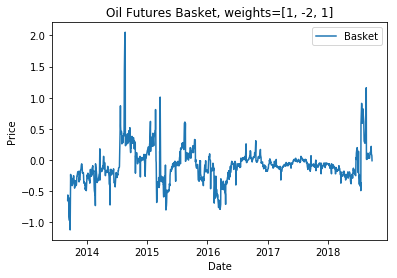

In [7]:
portfolio = (data['CL1'] - 2*data['CL2'] + data['CL3']).dropna()
p4 = plt.plot(portfolio,label='Basket')
plt.title('Oil Futures Basket, weights=[1, -2, 1]')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [8]:
# perform ADF test
from statsmodels.tsa.stattools import adfuller
test = adfuller(portfolio)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.131826
p-value: 0.000858
	1%: -3.436
	5%: -2.864
	10%: -2.568


The null hypothesis of portfolio prices having unit root can be rejected, the series are stationary 

**Q2**

Prove formulas (8) and (9) in Lecture Notes #4.

$$
\psi(L)=\alpha+\phi(L)\varepsilon_t\\
\bar{x_t}= \frac{\phi(L)}{\psi(L)}\epsilon_t=\gamma(L)\varepsilon_t
$$
let $\gamma_i$ be the coefficient of $L^{i}$, we have
\begin{align}
\Gamma(L)&=E(\bar{x_t}\bar{x_{t-h}})\\
         &=E(\gamma(L)\varepsilon_t\gamma(L)\varepsilon_{t-h})\\
         &=E(\sum_{j=-\infty}^{\infty}\gamma_j\gamma_{j+h}\varepsilon_{j}^{2}) \\
         &=\sigma^2 E(\sum_{j=-\infty}^{\infty}\gamma_j\gamma_{j+h})
\end{align}

\begin{align}
S_x(\omega)&=\frac{\sigma^2}{2\pi}\sum_{j=-\infty}^{\infty}\sum_{h=-\infty}^{\infty}\gamma_j\gamma_{j+h}e^{-i\omega h}\\
         &=\frac{\sigma^2}{2\pi}\sum_{j=-\infty}^{\infty}\gamma_je^{i\omega j}\sum_{h=-\infty}^{\infty}\gamma_{j+h}e^{-i\omega (j+h)}\\
         &=\frac{\sigma^2}{2\pi}\gamma(e^{i\omega})\gamma(e^{-i\omega})\\
         &=\frac{\sigma^2}{2\pi}|\gamma(e^{-i\omega})|^2\\
         &=\frac{\sigma^2}{2\pi}\frac{|\phi(e^{-i\omega})|^2}{|\psi(e^{-i\omega})|^2}
\end{align}


for $\omega\neq 0$ we are able to factorize the polynomials of $\phi(z)$ and $\psi(z)$
$$
S_x(\omega)=\frac{\sigma^2}{2\pi}\frac{|1-\mu_1 e^{-i\omega}|^2\cdots|1-\mu_q e^{-i\omega}|^2}{|1-\lambda_1 e^{-i\omega}|^2\cdots|1-\lambda_q e^{-i\omega}|^2}\\
$$

Then we have
$$
|1-\mu e^{-i\omega}|\\
=|1-\cos\omega+i\sin(-\omega)|\\
=\sqrt{(1-\mu \cos\omega)^2+(\mu\sin\omega)^2}\\
=\sqrt{1-2\mu \cos \omega +\mu^2}
$$

$$
S_x(\omega)=\frac{\sigma^2}{2\pi}\frac{(1-2\mu_1 \cos \omega +\mu_1^2)\cdots(1-2\mu_q \cos \omega +\mu_q^2)}{(1-2\lambda_1 \cos \omega +\lambda_1^2)\cdots(1-2\lambda_p \cos \omega +\lambda_p^2)}
$$